In [7]:
conda install scikit-image

Retrieving notices: ...working... done
Note: you may need to restart the kernel to use updated packages.

Channels:
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\devco\Desktop\project_heart_disease\env

  added / updated specs:
    - scikit-image


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2024.7.4           |  py310haa95532_0         159 KB
    imagecodecs-2023.1.23      |  py310h6c6a46e_0         8.9 MB
    imageio-2.33.1             |  py310haa95532_0         500 KB
    lazy_loader-0.4            |  py310haa95532_0          21 KB
    networkx-3.2.1             |  py310haa95532_0         2.4 MB
    openssl-1.1.1w             |       h2bbff1b_0         5.5 MB
    scikit-image-0.22.0        |  py310h25bd2df_0         9.6 MB
    tifffile-2023.4.12         |  py310haa95532_0         410 KB
    ------

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.measure import EllipseModel

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs

In [10]:
def plot(paths_XYs, colours):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]

        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    plt.show()

In [11]:
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev



In [12]:
def adjust_rectangle(points, max_width, max_height, scale_factor=0.95):
    min_coords = np.amin(points, axis=0)
    max_coords = np.amax(points, axis=0)

    rect_width = max_coords[0] - min_coords[0]
    rect_height = max_coords[1] - min_coords[1]

    scale_x = (max_width * scale_factor) / rect_width
    scale_y = (max_height * scale_factor) / rect_height

    center = np.mean(points, axis=0)

    # Create arrays for the x and y coordinates of the rectangle
    x_coords = np.array([min_coords[0], max_coords[0], max_coords[0], min_coords[0], min_coords[0]])
    y_coords = np.array([min_coords[1], min_coords[1], max_coords[1], max_coords[1], min_coords[1]])

    # Scale and adjust the coordinates
    x_scaled = center[0] + (x_coords - center[0]) * scale_x
    y_scaled = center[1] + (y_coords - center[1]) * scale_y

    # Return the scaled rectangle points
    return np.column_stack((x_scaled, y_scaled))


def adjust_circle(points, max_width, max_height, scale_factor=0.9):
    center = np.mean(points, axis=0)
    
    # Determine the median radius of the circle
    radius = np.median(np.linalg.norm(points - center, axis=1))

    # Calculate the scaling factor based on the smallest dimension
    min_dimension = min(max_width, max_height)
    scale = (min_dimension * scale_factor) / (2 * radius)

    # Generate points on a circle using the calculated scale
    num_points = points.shape[0]
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    x_coords = center[0] + radius * scale * np.cos(angles)
    y_coords = center[1] + radius * scale * np.sin(angles)

    return np.column_stack((x_coords, y_coords))


In [13]:
def adjust_star(points):
    center = np.mean(points, axis=0)

    # Determine the maximum radius from the center to the outermost points
    max_radius = np.max(np.linalg.norm(points - center, axis=1))
    
    # Set the inner radius as a fraction of the maximum radius for the star effect
    inner_radius = max_radius * 0.4

    # Define the number of points for the star (alternating outer and inner)
    num_vertices = 10
    angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)

    # Create an array of radii, alternating between outer and inner points
    radii = np.full(num_vertices, inner_radius)
    radii[::2] = max_radius  # Assign max radius to even indices (outer points)

    # Calculate the x and y coordinates for each vertex of the star
    x_coords = center[0] + radii * np.cos(angles)
    y_coords = center[1] + radii * np.sin(angles)

    # Ensure the star shape is closed by appending the first point at the end
    x_coords = np.append(x_coords, x_coords[0])
    y_coords = np.append(y_coords, y_coords[0])

    return np.column_stack((x_coords, y_coords))


In [14]:
def compute_perimeter(hull):
    # Initialize the perimeter to zero
    perimeter = 0
    num_vertices = len(hull.vertices)

    # Iterate over each pair of consecutive vertices to calculate distances
    for i in range(num_vertices):
        p1 = hull.points[hull.vertices[i]]
        p2 = hull.points[hull.vertices[(i + 1) % num_vertices]]
        perimeter += np.linalg.norm(p1 - p2)

    return perimeter

def estimate_num_vertices(points):
    # Compute the convex hull of the points
    hull = ConvexHull(points)

    # Return the number of vertices in the convex hull
    return len(hull.vertices)


In [17]:
def calculate_max_extents(points):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    return width, height

def calculate_aspect_ratio(points):
    hull = ConvexHull(points)
    hull_points = hull.points[hull.vertices]

    # Calculate distances between vertices
    dists = [np.linalg.norm(hull_points[i] - hull_points[(i + 1) % len(hull_points)]) for i in range(len(hull_points))]
    width, height = sorted(dists)[:2]

    return max(width, height) / min(width, height)


In [18]:
def identify_shape(points):
    if len(points) < 3:
        return 'unknown'  # Not enough points to determine shape

    # Compute the convex hull of the points
    hull = ConvexHull(points)
    hull_area = hull.volume
    hull_perimeter = compute_perimeter(hull)

    # If the perimeter is zero, the shape is indeterminate
    if hull_perimeter == 0:
        return 'unknown'

    # Calculate compactness (shape factor) to differentiate between shapes
    compactness = 4 * np.pi * hull_area / (hull_perimeter ** 2)
    
    print(f"Compactness: {compactness}, Hull Area: {hull_area}, Hull Perimeter: {hull_perimeter}")

    # Identify circle based on compactness
    if compactness > 0.90:
        print("Identified as circle")
        return 'circle'

    # Compute the aspect ratio of the bounding box for further shape identification
    aspect_ratio = calculate_aspect_ratio(points)
    
    # Identify rectangle based on aspect ratio
    if 0.7 < aspect_ratio < 1.2:
        print("Identified as rectangle")
        return 'rectangle'

    # Estimate the number of vertices to check for a star shape
    num_vertices = estimate_num_vertices(points)

    # Identify star based on the number of vertices and aspect ratio
    if num_vertices > 5 and (aspect_ratio < 0.9 or aspect_ratio > 2) and compactness < 0.9:
        print("Identified as star")
        return 'star'

    return 'unknown'


In [19]:
def bezier_curve_fit(points, num_points=100):
    tck, u = splprep(points.T, s=0)
    u_new = np.linspace(u.min(), u.max(), num_points)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.vstack((x_new, y_new)).T

In [20]:
def regularize_shape(points):
    # Handle empty input by returning an empty array
    if len(points) == 0:
        return np.array([])

    # Determine the maximum extents of the shape
    max_width, max_height = calculate_max_extents(points)

    # Identify the type of the shape
    shape_type = identify_shape(points)

    # Regularize the shape based on the identified type
    if shape_type == 'circle':
        return adjust_circle(points, max_width, max_height)
    elif shape_type == 'rectangle':
        return adjust_rectangle(points, max_width, max_height)
    elif shape_type == 'star':
        return adjust_star(points)
    else:
        return bezier_curve_fit(points)  # Fallback to bezier curve fitting for unknown shapes


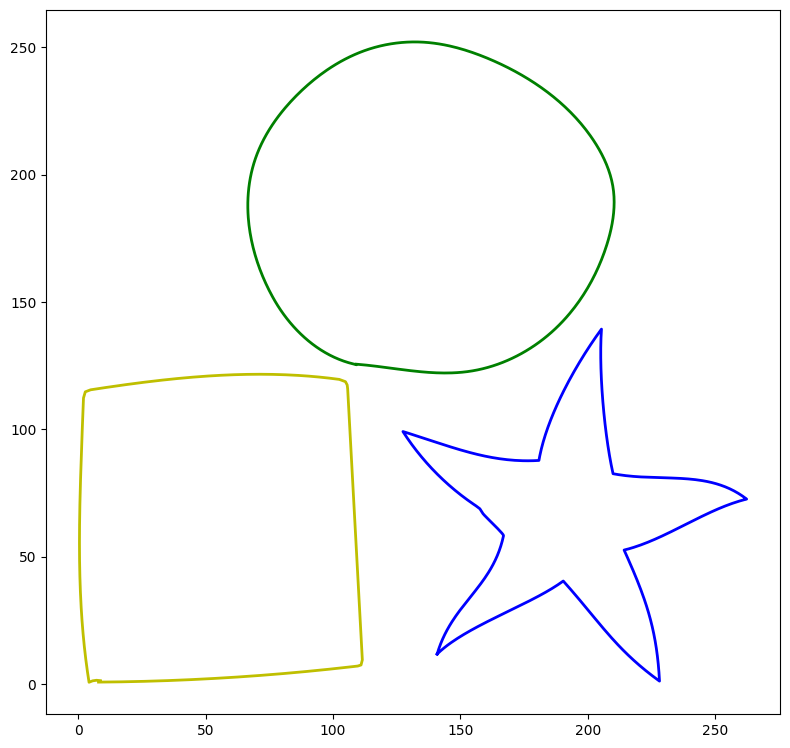

Compactness: 0.992289823063742, Hull Area: 14574.535798978466, Hull Perimeter: 429.6185540054191
Identified as circle
Compactness: 0.8633480837869744, Hull Area: 12747.868521835717, Hull Perimeter: 430.7554243917191
Identified as star
Compactness: 0.8290063799208852, Hull Area: 12521.755472778517, Hull Perimeter: 435.6709521916299
Identified as rectangle


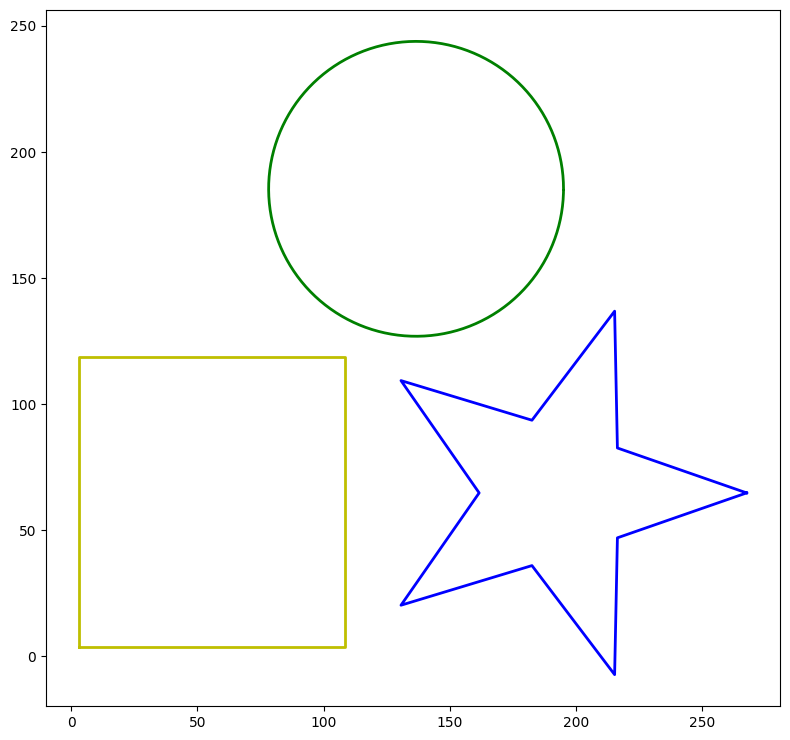

In [24]:

pathXY=read_csv('problems/isolated.csv')
colours = ['g', 'b', 'y', 'r']
regularized_path_XYs = []
plot(pathXY,colours)

for path in pathXY:
    regularized_path = []
    for shape in path:
        regularized_shape = regularize_shape(shape)
        regularized_path.append(regularized_shape)
    regularized_path_XYs.append(regularized_path)
plot(regularized_path_XYs, colours)

# Frags

In [25]:
from sklearn.cluster import DBSCAN
from scipy.interpolate import splprep, splev

In [26]:
def fit_bezier_curve(fragments):
    fragments = np.array(fragments)
    tck, u = splprep(fragments.T, s=0)
    u_fine = np.linspace(0, 1, 100)
    x_fine, y_fine = splev(u_fine, tck)
    return list(zip(x_fine, y_fine))


def group_fragments(fragments):
    coords = np.concatenate(fragments, axis=0)  # Combine all fragments into one array
    clustering = DBSCAN(eps=5, min_samples=2).fit(coords)
    labels = clustering.labels_

    grouped_fragments = {}
    for label, coord in zip(labels, coords):
        if label not in grouped_fragments:
            grouped_fragments[label] = []
        grouped_fragments[label].append(coord)
    return grouped_fragments



In [27]:
def merge_rectangle(fragments):
    x_coords, y_coords = zip(*fragments)
    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)
    return [
        (min_x, min_y),
        (max_x, min_y),
        (max_x, max_y),
        (min_x, max_y),
        (min_x, min_y)
    ]

def merge_circle(fragments):
    x_coords, y_coords = zip(*fragments)
    center_x, center_y = np.mean(x_coords), np.mean(y_coords)
    radius = np.mean([np.sqrt((x - center_x)**2 + (y - center_y)**2) for x, y in fragments])
    theta = np.linspace(0, 2 * np.pi, 100)
    return [(center_x + radius * np.cos(t), center_y + radius * np.sin(t)) for t in theta]

In [28]:
def identify_shape(fragments):
    if len(fragments) > 20:  
        return "circle"
    return "rectangle"

In [29]:
def separate_shapes(fragments):
    all_points = np.concatenate(fragments)

    min_x, min_y = np.min(all_points, axis=0)
    max_x, max_y = np.max(all_points, axis=0)

    margin = 5

    outer_points = []
    inner_points = []

    for point in all_points:
        if (point[0] <= min_x + margin or point[0] >= max_x - margin or
            point[1] <= min_y + margin or point[1] >= max_y - margin):
            outer_points.append(point)
        else:
            inner_points.append(point)

    return np.array(outer_points), np.array(inner_points)

In [30]:
def fit_bezier_curve(points):
    try:
        unique_points = np.unique(points, axis=0)
        if len(unique_points) < 4:
            print("Not enough unique points to fit a Bezier curve.")
            return None

        tck, u = splprep(unique_points.T, s=0, k=min(3, len(unique_points) - 1))
        u_new = np.linspace(0, 1, 100)
        x_new, y_new = splev(u_new, tck)
        return list(zip(x_new, y_new))
    except Exception as e:
        print(f"Error fitting Bezier curve: {e}")
        return None

In [31]:
def fit_rectangle(points):
    min_x, min_y = np.min(points, axis=0)
    max_x, max_y = np.max(points, axis=0)
    return [(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y), (min_x, min_y)]

def fit_circle(points):
    center = np.mean(points, axis=0)
    radius = np.mean(np.linalg.norm(points - center, axis=1))
    theta = np.linspace(0, 2 * np.pi, 100)
    return [(center[0] + radius * np.cos(t), center[1] + radius * np.sin(t)) for t in theta], center, radius

In [32]:
def filter_points_within_circle(points, center, radius):
    distances = np.sqrt((points[:, 0] - center[0])**2 + (points[:, 1] - center[1])**2)
    return points[distances < radius]  # Exclude boundary points

def plot_curves_within_circle(curves, center, radius):
    for curve in curves:
        x_curve, y_curve = zip(*curve)
        # Check if the curve points are within the circle
        distances = np.sqrt((np.array(x_curve) - center[0])**2 + (np.array(y_curve) - center[1])**2)
        if np.all(distances <= radius):
            plt.plot(x_curve, y_curve, '--', color='green', label='Inner Bezier Curve')


# Frag0

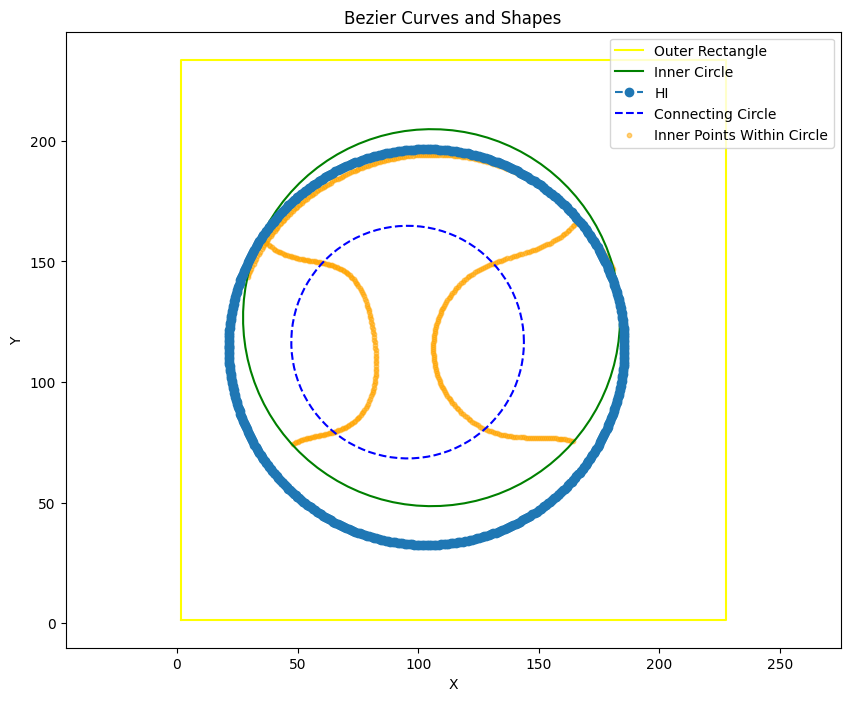

In [46]:
path_XYs = read_csv('problems/frag0.csv')
all_fragments = [fragment for shape_frag in path_XYs for fragment in shape_frag]
path_x = read_csv('problems/frag01_sol.csv')

sample_points =path_x[2][0]

# outer_points, inner_points = separate_shapes(all_fragments)

rectangle = fit_rectangle(outer_points)

# Fit circle
circle, center, radius = fit_circle(inner_points)

# inner_points_within_circle = filter_points_within_circle(inner_points, center, radius)

plt.figure(figsize=(10, 8))

x_rect, y_rect = zip(*rectangle)
plt.plot(x_rect, y_rect, '-', color='yellow', label='Outer Rectangle')

x_circle, y_circle = zip(*circle)
plt.plot(x_circle, y_circle, '-', color='green', label='Inner Circle')

plt.plot(sample_points[:, 0], sample_points[:, 1], 'o--', label="HI")

db = DBSCAN(eps=5, min_samples=10).fit(inner_points_within_circle)
labels = db.labels_

# Collect Bezier curves for each cluster
bezier_curves = []
unique_labels = set(labels)
for label in unique_labels:
    if label == -1:
        continue 

    cluster_points = inner_points_within_circle[labels == label]
    bezier_curve = fit_bezier_curve(cluster_points)
    if bezier_curve:
        bezier_curves.append(bezier_curve)

ellipse_centers = [np.mean(curve, axis=0) for curve in bezier_curves]
average_center = np.mean(ellipse_centers, axis=0)
average_radius = np.mean([np.mean(np.linalg.norm(np.array(curve) - average_center, axis=1)) for curve in bezier_curves])
theta = np.linspace(0, 2 * np.pi, 100)
connecting_circle = [(average_center[0] + average_radius * np.cos(t), average_center[1] + average_radius * np.sin(t)) for t in theta]

x_connecting_circle, y_connecting_circle = zip(*connecting_circle)
plt.plot(x_connecting_circle, y_connecting_circle, '--', color='blue', label='Connecting Circle')

plt.scatter(inner_points_within_circle[:, 0], inner_points_within_circle[:, 1], s=10, color='orange', alpha=0.5, label='Inner Points Within Circle')

plt.legend()
plt.title("Bezier Curves and Shapes")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.show()



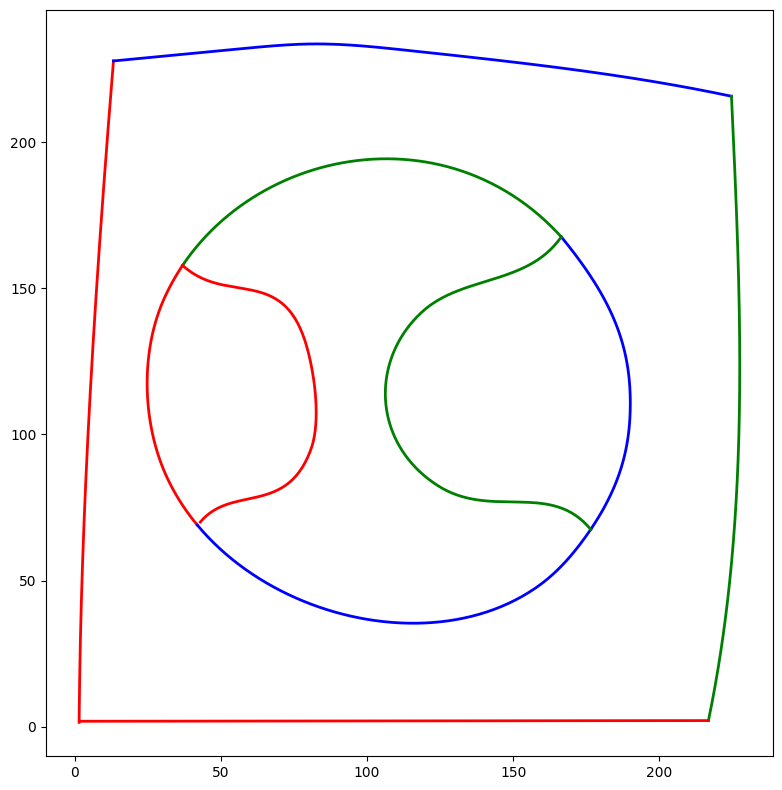

In [73]:
prob_path = "problems/frag0.csv"
colours = ['r', 'b', 'g']

plot(read_csv(prob_path), colours)

In [50]:
from scipy.optimize import minimize
from sklearn.cluster import DBSCAN


# Frag1

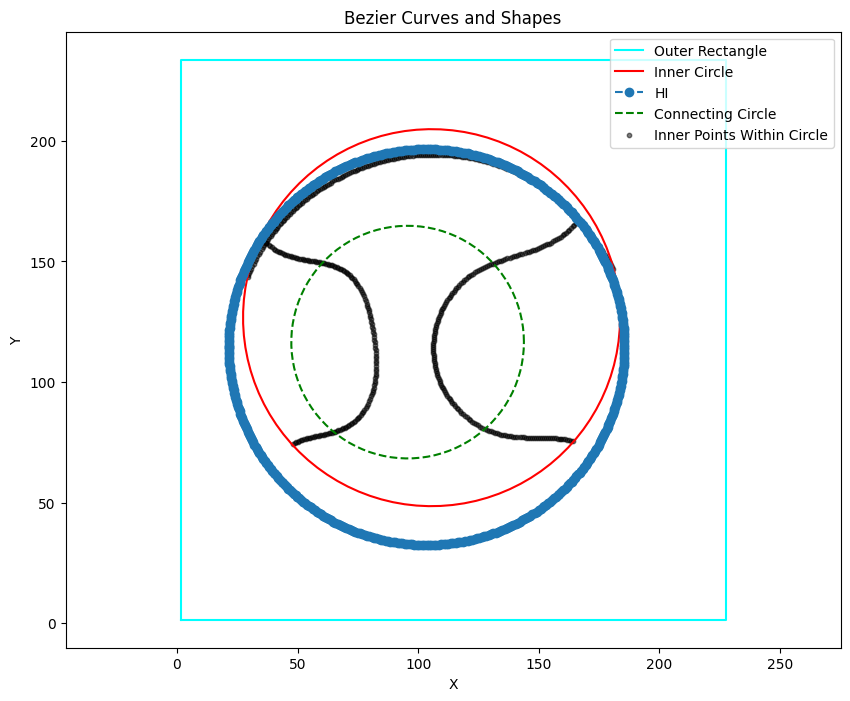

In [47]:
path_XYs = read_csv('problems/frag1.csv')
all_fragments = [fragment for shape_frag in path_XYs for fragment in shape_frag]
path_x = read_csv('problems/frag01_sol.csv')

sample_points =path_x[2][0]

rectangle = fit_rectangle(outer_points)

# Fit circle
circle, center, radius = fit_circle(inner_points)

plt.figure(figsize=(10, 8))

x_rect, y_rect = zip(*rectangle)
plt.plot(x_rect, y_rect, '-', color='cyan', label='Outer Rectangle')

x_circle, y_circle = zip(*circle)
plt.plot(x_circle, y_circle, '-', color='red', label='Inner Circle')

plt.plot(sample_points[:, 0], sample_points[:, 1], 'o--', label="HI")

db = DBSCAN(eps=5, min_samples=10).fit(inner_points_within_circle)
labels = db.labels_

# Collect Bezier curves for each cluster
bezier_curves = []
unique_labels = set(labels)
for label in unique_labels:
    if label == -1:
        continue 

    cluster_points = inner_points_within_circle[labels == label]
    bezier_curve = fit_bezier_curve(cluster_points)
    if bezier_curve:
        bezier_curves.append(bezier_curve)

ellipse_centers = [np.mean(curve, axis=0) for curve in bezier_curves]
average_center = np.mean(ellipse_centers, axis=0)
average_radius = np.mean([np.mean(np.linalg.norm(np.array(curve) - average_center, axis=1)) for curve in bezier_curves])
theta = np.linspace(0, 2 * np.pi, 100)
connecting_circle = [(average_center[0] + average_radius * np.cos(t), average_center[1] + average_radius * np.sin(t)) for t in theta]

x_connecting_circle, y_connecting_circle = zip(*connecting_circle)
plt.plot(x_connecting_circle, y_connecting_circle, '--', color='green', label='Connecting Circle')

plt.scatter(inner_points_within_circle[:, 0], inner_points_within_circle[:, 1], s=10, color='black', alpha=0.5, label='Inner Points Within Circle')

plt.legend()
plt.title("Bezier Curves and Shapes")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.show()



# Frag2

In [52]:
pip install rdp

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for rdp: filename=rdp-0.8-py3-none-any.whl size=4605 sha256=00f8b0369e39802dcd11f660836794feca902cb315d05e95f8616e29f70c2a41
  Stored in directory: c:\users\devco\appdata\local\pip\cache\wheels\5d\12\ec\0fc50553af000b9c3d2c74b9f77a01ae4bfe856e9917ac239c
Successfully built rdp
Note: you may need to restart the kernel to use updated packages.


In [61]:
from rdp import rdp

In [62]:
def plot_paths(path_XYs, colours):
    fig, ax = plt.subplots(figsize=(8, 8))
    color_idx = 0
    for path in path_XYs:
        for segment in path:
            if len(segment) > 0:
                segment = np.array(segment)
                ax.plot(segment[:, 0], segment[:, 1], c=colours[color_idx % len(colours)], linewidth=2)
        color_idx += 1
    ax.set_aspect('equal')
    plt.xlim(0, 150)
    plt.ylim(0, 150)
    plt.grid(True, which='both', color='lightgray', linestyle='--')
    plt.show()

In [70]:
def apply_rdp(path_XYs, epsilon=1.2):
    simplified_paths = []
    for path in path_XYs:
        simplified_path = [rdp(segment, epsilon=epsilon) for segment in path]
        simplified_paths.append(simplified_path)
    return simplified_paths

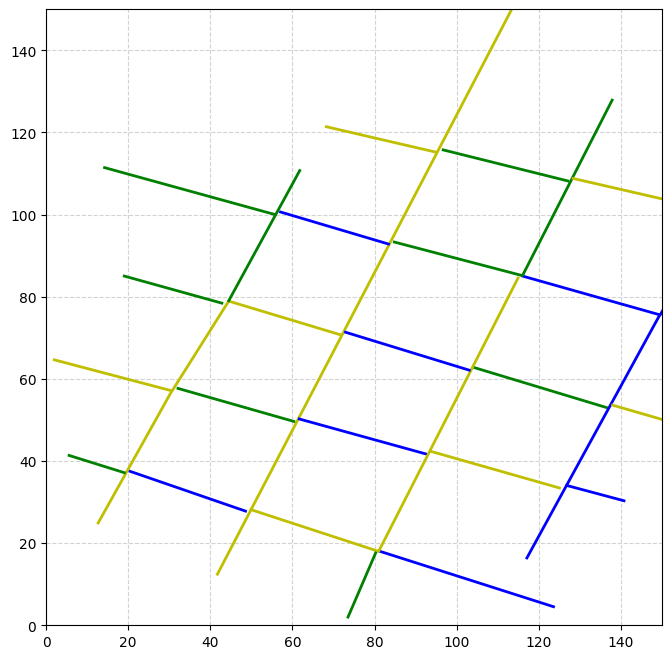

In [71]:
csv_path2 = "problems/frag2.csv"
path_XYs = read_csv(csv_path2)
simplified_paths = apply_rdp(path_XYs, epsilon=1.2)

# Define colors
colours = ['b', 'g', 'y']

# Plot the result
plot_paths(simplified_paths, colours)
     

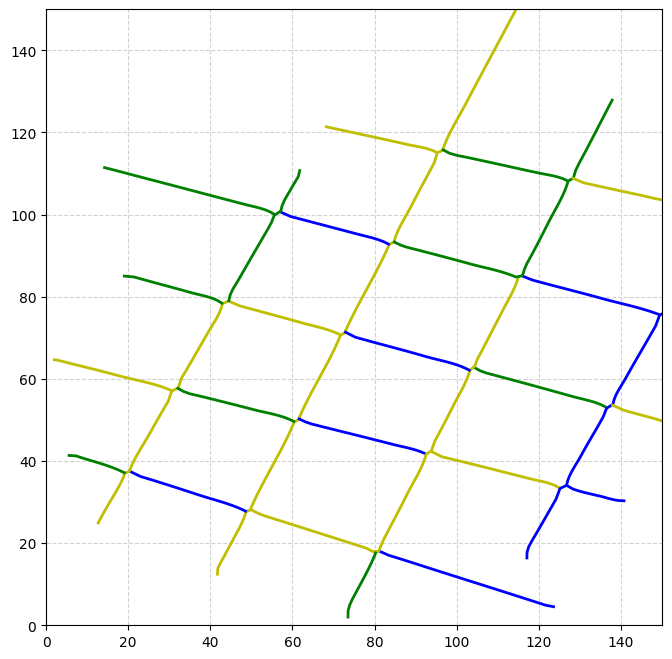

In [72]:
csv_path_prob = "problems/frag2.csv"
path_XYs = read_csv(csv_path_prob)
# Define colors
colours = ['b', 'g', 'y']

# Plot the result
plot_paths(path_XYs, colours)
     